# Pill

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from models import VAE_sigmoid, VAE_tanh, initialize_weights
from utils import visualize_pixel_distribution, show_8x4_images, plot_training_validation_loss, visualize_reconstruction, plot_and_calculate_losses
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataset import SingleFolderDataset
from train_model import vae_loss, train_vae
from test_model import calculate_losses_for_category, calculate_metrics


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4070 SUPER , device num:0


In [4]:
train_data_path = 'data/train/pill'
val_data_path = 'data/val/pill'
test_data_path = 'data/test/pill'

In [5]:
image_size = 256

learning_rate = 0.0001
batch_size = 32
input_dim=3
feature_dim=64
latent_dim=256

epochs = 500

## Train

In [6]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

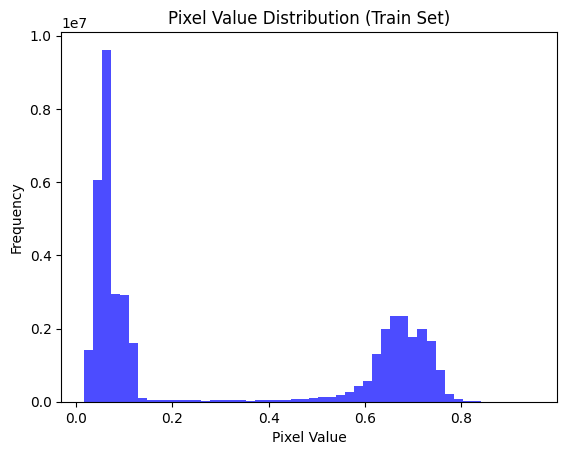

In [7]:
visualize_pixel_distribution(train_loader)

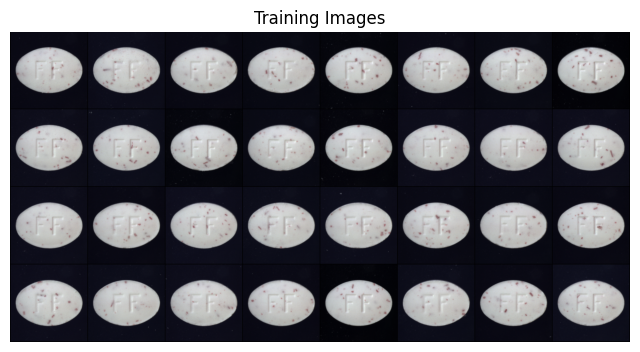

In [8]:
show_8x4_images(train_loader)

In [9]:
vae_sigmoid = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(vae_sigmoid)

optimizer = optim.Adam(vae_sigmoid.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

train_losses_sigmoid, val_losses_sigmoid = train_vae(vae_sigmoid, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 36653.5179, Val Loss: 21349.4549
Epoch [2/500]: Train Loss: 23444.5459, Val Loss: 15685.3397
Epoch [3/500]: Train Loss: 13773.8935, Val Loss: 12209.3293
Epoch [4/500]: Train Loss: 9419.1252, Val Loss: 11936.2338
Epoch [5/500]: Train Loss: 7220.5604, Val Loss: 11147.2648
Epoch [6/500]: Train Loss: 5792.7036, Val Loss: 9034.1050
Epoch [7/500]: Train Loss: 4724.8666, Val Loss: 6674.6742
Epoch [8/500]: Train Loss: 3924.1271, Val Loss: 4614.6916
Epoch [9/500]: Train Loss: 3325.0869, Val Loss: 3376.5644
Epoch [10/500]: Train Loss: 2875.8143, Val Loss: 2771.2651
Epoch [11/500]: Train Loss: 2512.5922, Val Loss: 2364.1643
Epoch [12/500]: Train Loss: 2202.4027, Val Loss: 2063.3069
Epoch [13/500]: Train Loss: 1930.9661, Val Loss: 1801.5477
Epoch [14/500]: Train Loss: 1704.8584, Val Loss: 1593.1379
Epoch [15/500]: Train Loss: 1512.1750, Val Loss: 1407.9354
Epoch [16/500]: Train Loss: 1353.2782, Val Loss: 1264.4108
Epoch [17/500]: Train Loss: 1219.0952, Val Loss: 1138.665

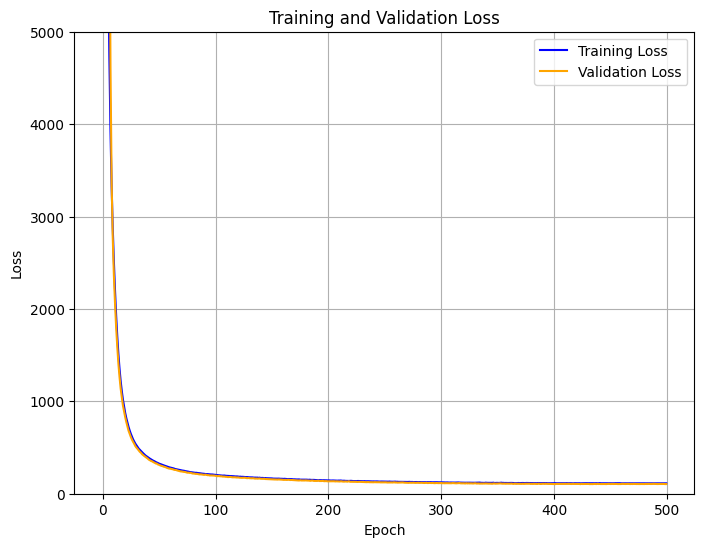

In [10]:
plot_training_validation_loss(train_losses_sigmoid, val_losses_sigmoid, (0, 5000))

In [ ]:
# torch.save(vae_sigmoid.state_dict(), "params/pill_sigmoid.pth")

### 資料正規化到 [-1, 1]，使用 Tanh 當作激活函數，並使用較小的 learning rate

In [6]:
learning_rate=0.00005
a=0.3

In [7]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images to [-1, 1] range
])


train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

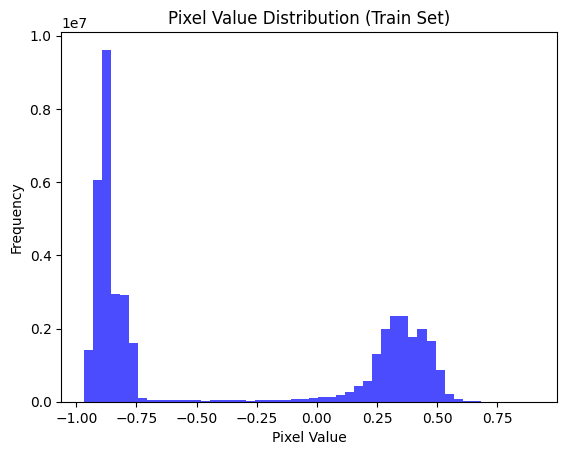

In [8]:
visualize_pixel_distribution(train_loader)

In [9]:
vae_tanh = VAE_tanh(input_dim, feature_dim, latent_dim, a=a).to(device)
initialize_weights(vae_tanh)

In [10]:
optimizer = optim.Adam(vae_tanh.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

train_losses_tanh, val_losses_tanh = train_vae(vae_tanh, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 51846981.3099, Val Loss: 89370.7523
Epoch [2/500]: Train Loss: 1091030.3474, Val Loss: 79779.2940
Epoch [3/500]: Train Loss: 1042050.8779, Val Loss: 74306.3981
Epoch [4/500]: Train Loss: 115426.7688, Val Loss: 70389.1505
Epoch [5/500]: Train Loss: 49448.1696, Val Loss: 74394.5787
Epoch [6/500]: Train Loss: 40544.7697, Val Loss: 84247.1181
Epoch [7/500]: Train Loss: 41009.9665, Val Loss: 76607.5833
Epoch [8/500]: Train Loss: 28853.0913, Val Loss: 71372.1343
Epoch [9/500]: Train Loss: 24960.5871, Val Loss: 60670.4861
Epoch [10/500]: Train Loss: 24480.0817, Val Loss: 33162.3032
Epoch [11/500]: Train Loss: 22849.6918, Val Loss: 21058.6597
Epoch [12/500]: Train Loss: 17628.2858, Val Loss: 18802.6985
Epoch [13/500]: Train Loss: 15990.1689, Val Loss: 17325.6597
Epoch [14/500]: Train Loss: 15733.2535, Val Loss: 13897.0122
Epoch [15/500]: Train Loss: 13903.7694, Val Loss: 13136.3345
Epoch [16/500]: Train Loss: 12935.1161, Val Loss: 11675.6337
Epoch [17/500]: Train Los

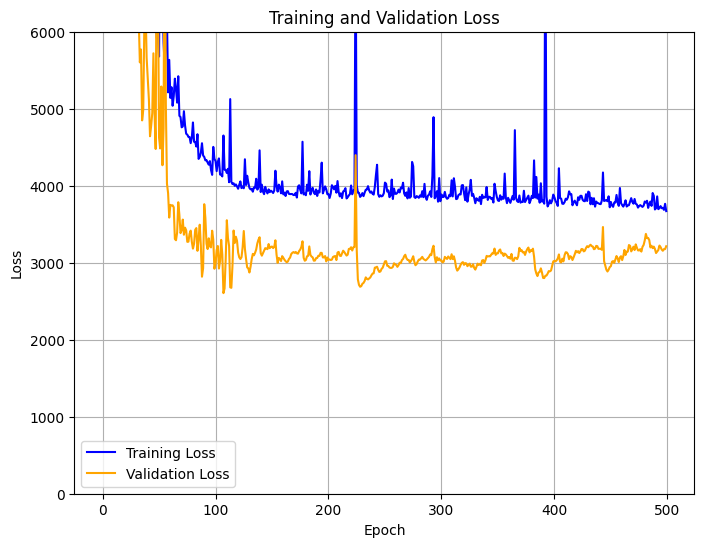

In [12]:
plot_training_validation_loss(train_losses_tanh, val_losses_tanh, (0, 6000))

In [13]:
# torch.save(vae_tanh.state_dict(), "params/pill_tanh.pth")

## Test

In [20]:
model = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
model.load_state_dict(torch.load("params/pill_sigmoid.pth"))

C:\Users\wei\AppData\Local\Temp\ipykernel_41700\2370391260.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("params/pill_sigmoid.pth"))


<All keys matched successfully>

In [21]:
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# inverse_transform = transforms.Compose([
#     transforms.Lambda(lambda x: x * 0.5 + 0.5),  # 乘上標準差後加上均值
#     transforms.ToPILImage()
# ])

In [22]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

inverse_transform = transforms.Compose([
    transforms.ToPILImage()
])

Error:
loss: 82.733642578125


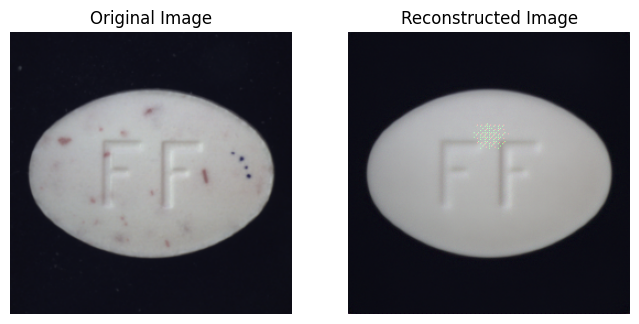

Good:
loss: 104.75627899169922


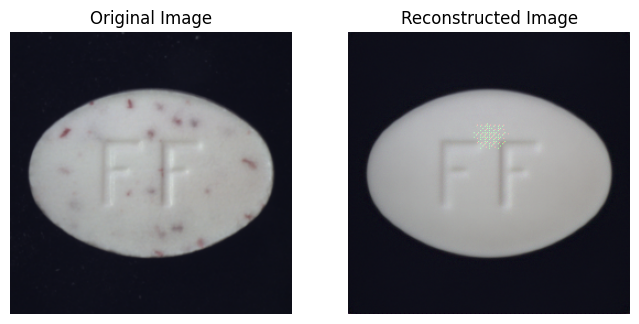

In [23]:
print("Error:")
image_path = "data/test/pill/error/0.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

print("Good:")
image_path = "data/test/pill/good/000.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

good avg:  109.71216671283429
defective avg:  162.78147455310145


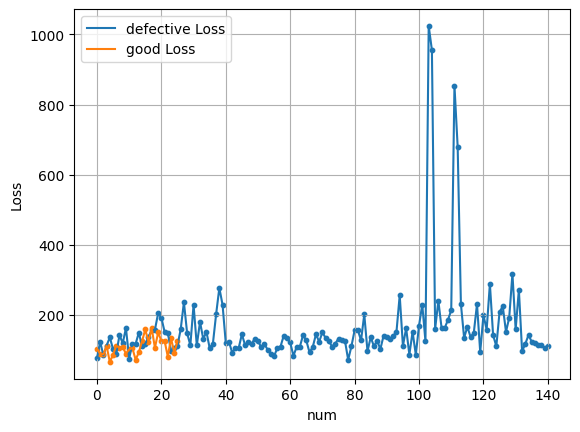

In [24]:
good_losses, error_losses = calculate_losses_for_category(test_data_path, model, vae_loss, transform, device=device)

plot_and_calculate_losses(good_losses, error_losses)

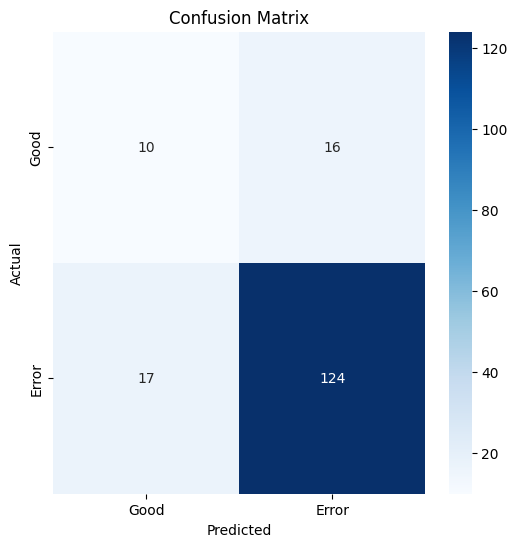

accuracy: 0.8023952095808383, F1 score: 0.8825622775800712


In [27]:
threshold = 100

accuracy, f1_score = calculate_metrics(test_data_path, model, vae_loss, transform, threshold, device=device)
print(f'accuracy: {accuracy}, F1 score: {f1_score}')